# Import Library yang Diperlukan

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt;
from statsmodels.tsa.seasonal import seasonal_decompose
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer
import warnings
warnings.filterwarnings('ignore')


# Input data files are available in the read-only "../input/" directory

import os
for dirname, _, filenames in os.walk('/kaggle/input/datacard'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [2]:
df_card = pd.read_csv('/kaggle/input/prediksidata/prediksidata.csv')

**Melihat Dataset yang ada**

In [3]:
df_card.head()

,Bulan,Jumlah_Panen_Padi
0,1,1075
1,2,1084
2,3,9870
3,4,1058
4,5,1203


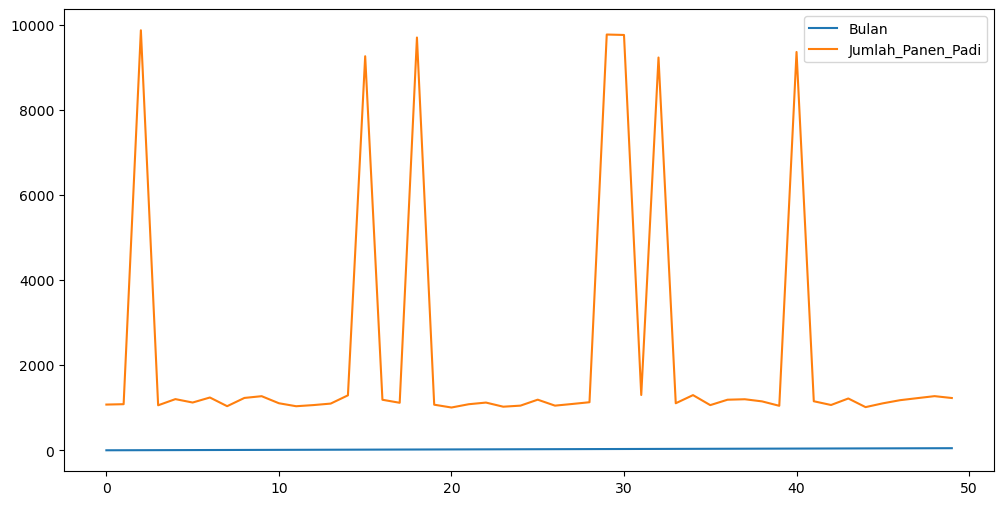

In [4]:
df_card.plot(figsize=(12,6));

In [31]:
# Train Test Split
train = df_card[0:38]
test = df_card[38:50]

**Melihat data train**

In [6]:
train

,Bulan,Jumlah_Panen_Padi
0,1,1075
1,2,1084
2,3,9870
3,4,1058
4,5,1203
5,6,1123
6,7,1241
7,8,1037
8,9,1231
9,10,1272


**Melihat data test**

In [7]:
test

,Bulan,Jumlah_Panen_Padi
38,39,1150
39,40,1046
40,41,9360
41,42,1153
42,43,1065
43,44,1218
44,45,1015
45,46,1104
46,47,1178
47,48,1226


# Membangun data latihan dan target yang akan digunakan dalam pemodelan prediksi

In [8]:
def lag(df, n):
    X, y = [], []
    for i in range(len(df) - n):
        X.append(df[i:i+n])
        y.append(df[n+i])
    
    return np.array(X), np.array(y), np.array(y[-n:]).reshape(1,n)


In [9]:
X, y, last_batch_values = lag(train.Jumlah_Panen_Padi.values, 12)

In [10]:
X

array([[1075, 1084, 9870, 1058, 1203, 1123, 1241, 1037, 1231, 1272, 1106,
        1036],
       [1084, 9870, 1058, 1203, 1123, 1241, 1037, 1231, 1272, 1106, 1036,
        1063],
       [9870, 1058, 1203, 1123, 1241, 1037, 1231, 1272, 1106, 1036, 1063,
        1098],
       [1058, 1203, 1123, 1241, 1037, 1231, 1272, 1106, 1036, 1063, 1098,
        1292],
       [1203, 1123, 1241, 1037, 1231, 1272, 1106, 1036, 1063, 1098, 1292,
        9260],
       [1123, 1241, 1037, 1231, 1272, 1106, 1036, 1063, 1098, 1292, 9260,
        1188],
       [1241, 1037, 1231, 1272, 1106, 1036, 1063, 1098, 1292, 9260, 1188,
        1117],
       [1037, 1231, 1272, 1106, 1036, 1063, 1098, 1292, 9260, 1188, 1117,
        9700],
       [1231, 1272, 1106, 1036, 1063, 1098, 1292, 9260, 1188, 1117, 9700,
        1072],
       [1272, 1106, 1036, 1063, 1098, 1292, 9260, 1188, 1117, 9700, 1072,
        1006],
       [1106, 1036, 1063, 1098, 1292, 9260, 1188, 1117, 9700, 1072, 1006,
        1083],
       [1036, 1063, 1

In [11]:
y

array([1063, 1098, 1292, 9260, 1188, 1117, 9700, 1072, 1006, 1083, 1122,
       1025, 1050, 1190, 1050, 1089, 1130, 9770, 9760, 1300, 9230, 1106,
       1297, 1062, 1189, 1200])

In [12]:
last_batch_values

array([[1050, 1089, 1130, 9770, 9760, 1300, 9230, 1106, 1297, 1062, 1189,
        1200]])

# Membuat Model untuk Melatih dan Membangun Model Multi Layer Perceptron

In [13]:
def mlp(input_, y_, epochs):
    model = Sequential()
    model.add(Dense(10, activation='relu', input_dim=input_.shape[1]))
    model.add(Dense(15, activation='relu'))
    model.add(Dense(1))

#   opt = keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer='adam', loss='mape')
    print(model.fit(input_, y_, epochs=epochs))
    return model

In [14]:
model = mlp(X, y, 300)
model.summary()

Epoch 1/300
1/1 [==============================] - 1s 984ms/step - loss: 157.6920
Epoch 2/300
1/1 [==============================] - 0s 6ms/step - loss: 152.9379
Epoch 3/300
1/1 [==============================] - 0s 7ms/step - loss: 148.2601
Epoch 4/300
1/1 [==============================] - 0s 7ms/step - loss: 143.6350
Epoch 5/300
1/1 [==============================] - 0s 7ms/step - loss: 139.0583
Epoch 6/300
1/1 [==============================] - 0s 7ms/step - loss: 134.5145
Epoch 7/300
1/1 [==============================] - 0s 6ms/step - loss: 130.0213
Epoch 8/300
1/1 [==============================] - 0s 7ms/step - loss: 125.6562
Epoch 9/300
1/1 [==============================] - 0s 6ms/step - loss: 121.4304
Epoch 10/300
1/1 [==============================] - 0s 5ms/step - loss: 117.2756
Epoch 11/300
1/1 [==============================] - 0s 6ms/step - loss: 113.1914
Epoch 12/300
1/1 [==============================] - 0s 7ms/step - loss: 109.1919
Epoch 13/300
1/1 [=================

# Membuat Fungsi Prediksi Nilai menggunakan Model

In [15]:
def fungsi_prediksi(model, batch_terakhir, n):
    in_value = last_batch_values.copy()
    preds = []
    for i in range(n):
        p = model.predict(in_value)
        preds.append(p.ravel())
        in_value = np.append(in_value, p)[1:].reshape(batch_terakhir.shape)
    return np.array(preds).ravel()

In [16]:
pred = fungsi_prediksi(model, last_batch_values, 12)

1/1 [==============================] - 0s 24ms/step


In [17]:
pred

array([1194.6299 , 2050.8157 , 1876.5532 , 1697.6418 , 1786.6383 ,
       1107.1909 , 1457.0791 ,  605.67175,  552.7596 ,  540.743  ,
        528.7001 ,  543.6086 ], dtype=float32)

In [18]:
test['Prediksi_Jumlah'] = pred[:len(test)]

In [19]:
test

,Bulan,Jumlah_Panen_Padi,Prediksi_Jumlah
38,39,1150,1194.629883
39,40,1046,2050.815674
40,41,9360,1876.553223
41,42,1153,1697.641846
42,43,1065,1786.638306
43,44,1218,1107.190918
44,45,1015,1457.079102
45,46,1104,605.671753
46,47,1178,552.759583
47,48,1226,540.742981


# Grafik Perbedaan Penjualan asli dan Penjualan yang di Prediksi

<Axes: >

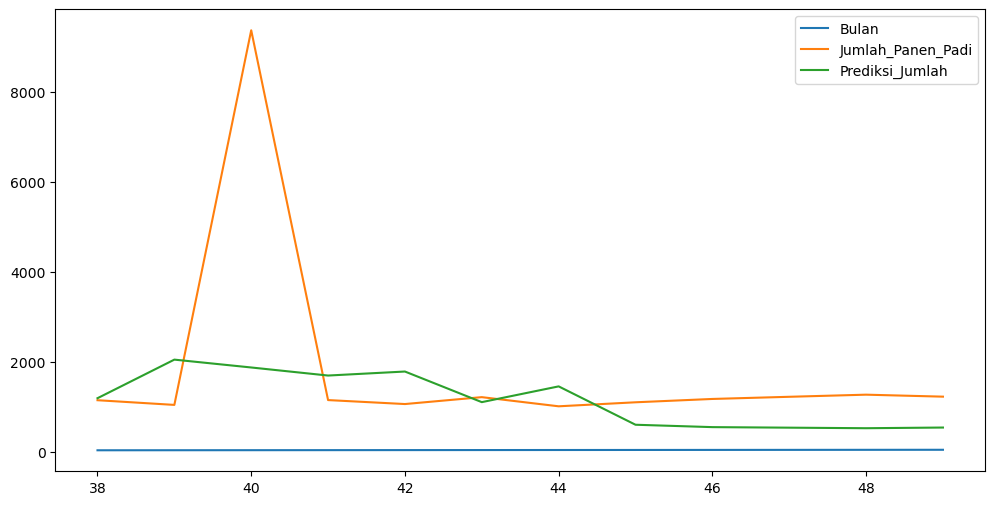

In [20]:
test.plot(figsize=(12,6))

# Menghitung Tingkat Error antara Penjualan dan Prediksi Penjualan

In [21]:
def error_function(df, column_1, column_2):
    data = df.copy()
    my_list = []
    
    for _, row in data.iterrows():
        x = (row[column_2] * 100) / row[column_1]

        if x >= 100:
            error = x - 100
            my_list.append(error)
        else:
            error = 100 - x
            my_list.append(error)

    data['error_percentage'] = my_list

    return data



In [22]:
column_1 = 'Jumlah_Panen_Padi'
column_2 = 'Prediksi_Jumlah'
df_new = error_function(test, column_1, column_2)
df_new

,Bulan,Jumlah_Panen_Padi,Prediksi_Jumlah,error_percentage
38,39,1150,1194.629883,3.880859
39,40,1046,2050.815674,96.062684
40,41,9360,1876.553223,79.951354
41,42,1153,1697.641846,47.236934
42,43,1065,1786.638306,67.759465
43,44,1218,1107.190918,9.097626
44,45,1015,1457.079102,43.554591
45,46,1104,605.671753,45.138428
46,47,1178,552.759583,53.076436
47,48,1226,540.742981,55.893721


# Mencari Nilai Maen Absolute Error

In [23]:
def mean_absolute_error(actual, predicted):
    return np.mean(np.abs(actual - predicted))
actual = sum(df_new.Jumlah_Panen_Padi.values)
predicted = sum(df_new.Prediksi_Jumlah.values)
mae = mean_absolute_error(actual, predicted)

In [24]:
print("MAE:", mae)

MAE: 8074.968078613281


# Mencari Nilai Maen Absolute Percentage Error

In [25]:
def mean_absolute_percentage_error(actual, predicted):
    return np.mean(np.abs((actual - predicted) / actual)) * 100
actual = sum(df_new.Jumlah_Panen_Padi.values)
predicted = sum(df_new.Prediksi_Jumlah.values)
mape = mean_absolute_percentage_error(actual, predicted)

In [26]:
print("MAPE:", mape)

MAPE: 36.67605976569597
